# Adversial Phyiscs Informed Neural Networks

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
import numpy as np, matplotlib.pyplot as plt, math

# Deterministic setup
torch.manual_seed(42); np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Defining burgers equations

In [ ]:
def burgers_uv(x, y, t, nu, x0=0.5, y0=0.5, A=1.0, t0=0.3):
    """Exact smooth solution to 2D Burgers' eq via Cole–Hopf transform."""
    denom = 4 * math.pi * nu * (t + t0)
    r2 = (x - x0)**2 + (y - y0)**2
    phi = 1 + A * math.exp(-r2 / (4 * nu * (t + t0))) / (denom + 1e-9)
    dphidx = A * math.exp(-r2 / (4 * nu * (t + t0))) * (-(x - x0) / (2 * nu * (t + t0))) / (denom + 1e-9)
    dphidy = A * math.exp(-r2 / (4 * nu * (t + t0))) * (-(y - y0) / (2 * nu * (t + t0))) / (denom + 1e-9)
    u = -2 * nu * dphidx / (phi + 1e-9)
    v = -2 * nu * dphidy / (phi + 1e-9)
    return u, v

## make dataset

In [ ]:
def make_dataset(nu_list, n=20):
    xs, ys, ts = np.linspace(0,1,n), np.linspace(0,1,n), np.linspace(0,1,n)
    X, Y, T, NU, U, V = [], [], [], [], [], []
    for nu in nu_list:
        for x in xs:
            for y in ys:
                for t in ts:
                    u,v = burgers_uv(x,y,t,nu)
                    X.append(x); Y.append(y); T.append(t); NU.append(nu)
                    U.append(u); V.append(v)
    data = torch.tensor(np.stack([X,Y,T,NU],axis=1),dtype=torch.float32)
    targets = torch.tensor(np.stack([U,V],axis=1),dtype=torch.float32)
    return data.to(device), targets.to(device)

nu_train, nu_test = [0.01], [0.02]
train_X, train_Y = make_dataset(nu_train, n=16)
test_X,  test_Y  = make_dataset(nu_test,  n=16)
print("Train shape:", train_X.shape, train_Y.shape)


Train shape: torch.Size([4096, 4]) torch.Size([4096, 2])


## Visualize the created dataset (chatgpt)

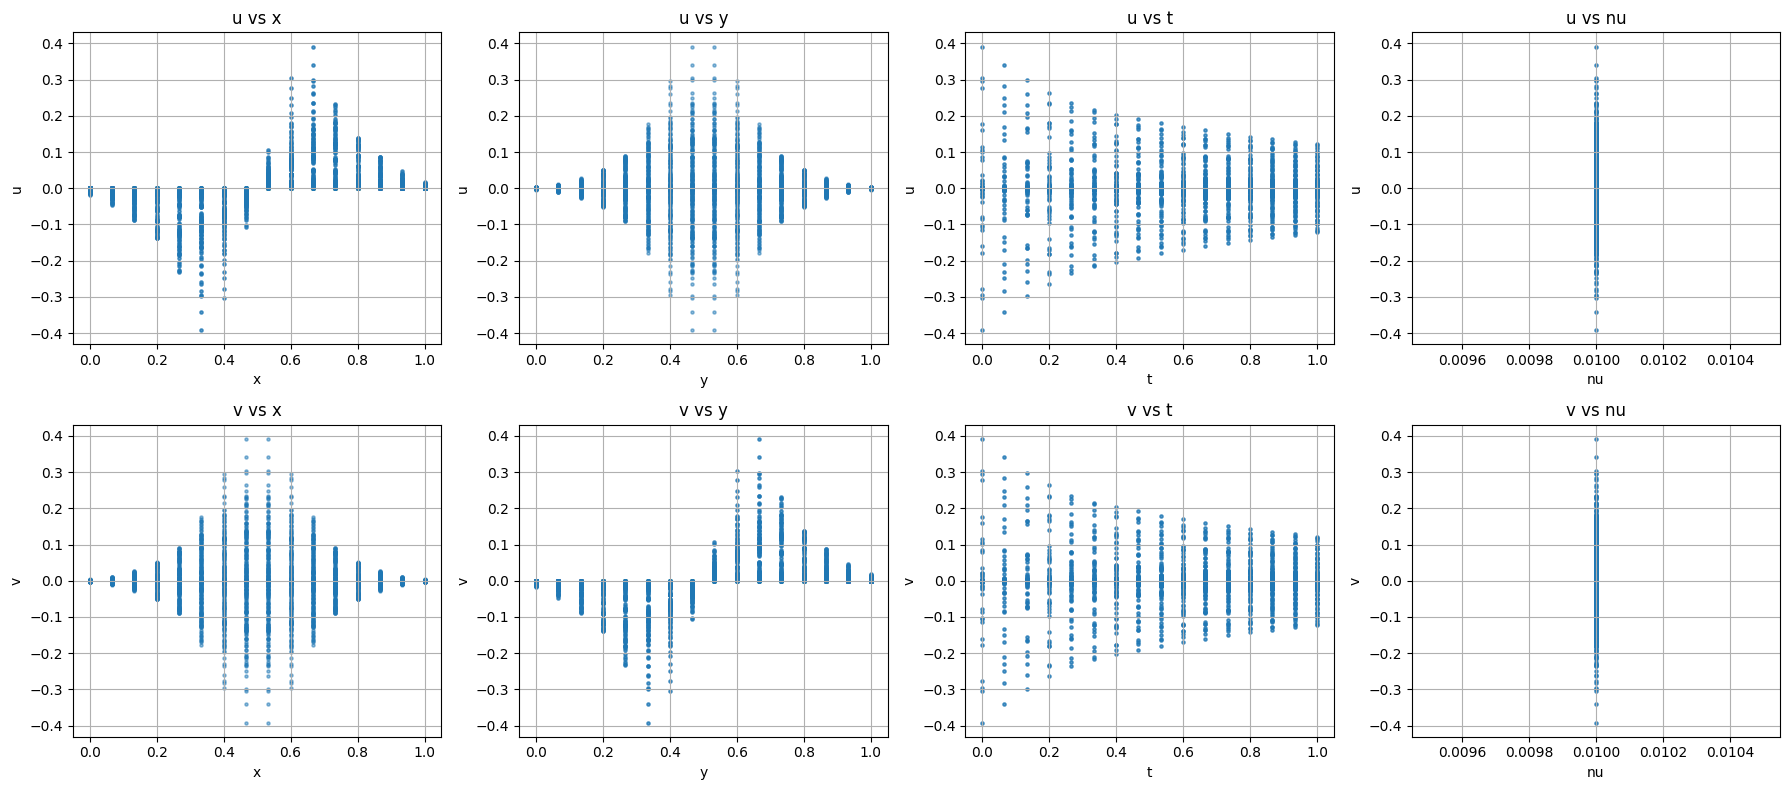

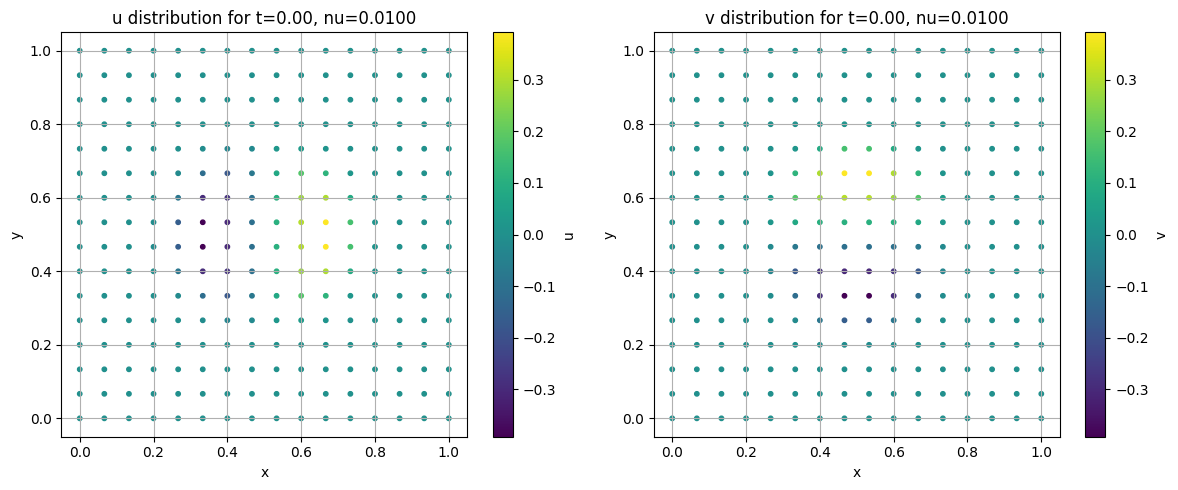

In [ ]:
# Convert tensors to numpy for plotting
train_X_np = train_X.cpu().numpy()
train_Y_np = train_Y.cpu().numpy()

# Plotting u and v against each input feature
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
input_features = ['x', 'y', 't', 'nu']
output_features = ['u', 'v']

for i in range(4): # Loop over input features
    for j in range(2): # Loop over output features
        axes[j, i].scatter(train_X_np[:, i], train_Y_np[:, j], s=5, alpha=0.5)
        axes[j, i].set_xlabel(input_features[i])
        axes[j, i].set_ylabel(f'{output_features[j]}')
        axes[j, i].set_title(f'{output_features[j]} vs {input_features[i]}')
        axes[j, i].grid(True)

plt.tight_layout()
plt.show()

# Example of a 2D slice plot (e.g., u vs x and y for fixed t and nu)
# This requires selecting a specific t and nu value from your dataset.
# For simplicity, let's pick the first t and nu value in the training data

fixed_t = train_X_np[0, 2]
fixed_nu = train_X_np[0, 3]

# Filter data for the chosen fixed values (with a small tolerance)
tolerance = 1e-5
mask = np.isclose(train_X_np[:, 2], fixed_t, atol=tolerance) & \
       np.isclose(train_X_np[:, 3], fixed_nu, atol=tolerance)

x_slice = train_X_np[mask, 0]
y_slice = train_X_np[mask, 1]
u_slice = train_Y_np[mask, 0]
v_slice = train_Y_np[mask, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_slice, y_slice, c=u_slice, cmap='viridis', s=10)
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'u distribution for t={fixed_t:.2f}, nu={fixed_nu:.4f}')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(x_slice, y_slice, c=v_slice, cmap='viridis', s=10)
plt.colorbar(label='v')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'v distribution for t={fixed_t:.2f}, nu={fixed_nu:.4f}')
plt.grid(True)

plt.tight_layout()
plt.show()

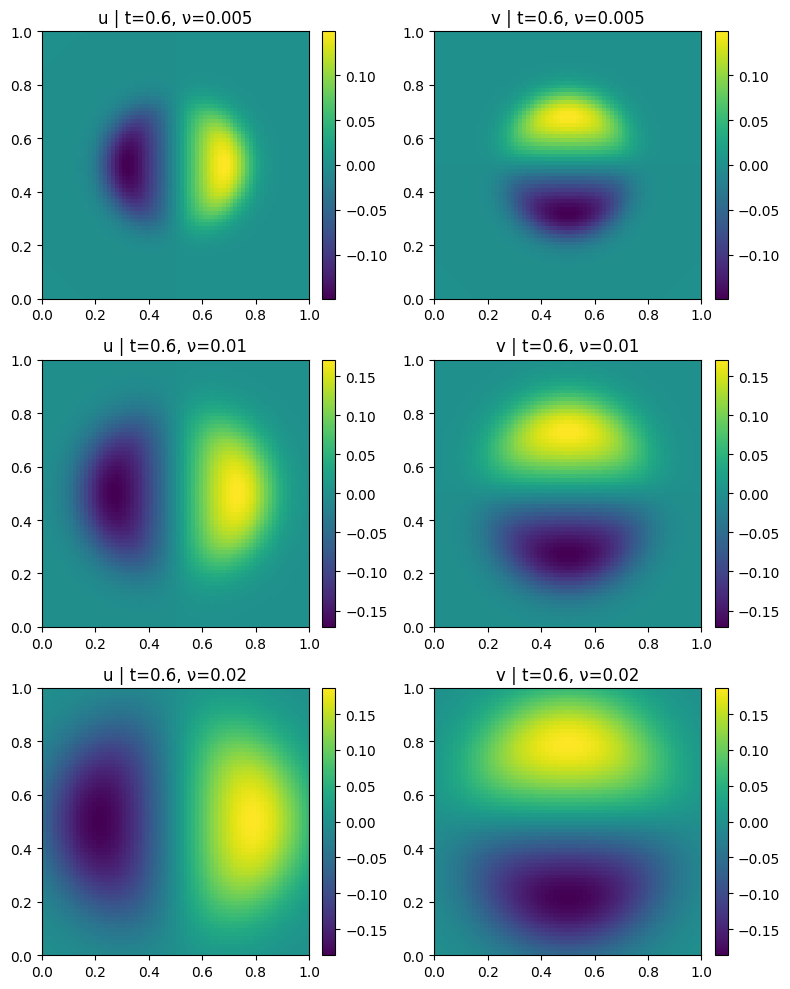

In [ ]:
def field_on_grid(nu, t, n=60):
    xs = np.linspace(0,1,n); ys = np.linspace(0,1,n)
    U = np.zeros((n,n), dtype=np.float32)
    V = np.zeros((n,n), dtype=np.float32)
    for i,x in enumerate(xs):
        for j,y in enumerate(ys):
            u,v = burgers_uv(float(x), float(y), float(t), float(nu))
            U[j,i] = u; V[j,i] = v
    return xs, ys, U, V

fig, axs = plt.subplots(3, 2, figsize=(8, 10))
nus_demo = [0.005, 0.01, 0.02]; t_demo = 0.6
for r, nu in enumerate(nus_demo):
    xs, ys, U, V = field_on_grid(nu, t_demo, n=70)
    im0 = axs[r,0].imshow(U, extent=[0,1,0,1], origin='lower'); axs[r,0].set_title(f"u | t={t_demo}, ν={nu}")
    im1 = axs[r,1].imshow(V, extent=[0,1,0,1], origin='lower'); axs[r,1].set_title(f"v | t={t_demo}, ν={nu}")
    fig.colorbar(im0, ax=axs[r,0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=axs[r,1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

## Defining the basic PINN model

In [ ]:
class PINN(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2)
        )
    def forward(self, x):
        return self.net(x)

pinn = PINN().to(device)

## Auto differentiation to calculate the derivatives

In [ ]:
def burgers_residuals(model, x):
    x_requires_grad = x.clone().detach().requires_grad_(True)
    out = model(x_requires_grad)
    u, v = out[:,0:1], out[:,1:2]
    # x_, y_, t_, nu = x_requires_grad[:,0:1], x_requires_grad[:,1:2], x_requires_grad[:,2:3], x_requires_grad[:,3:4]
    # We'll use slicing on the gradients instead of the input tensor directly

    # Compute first derivatives with respect to the whole input tensor
    grads_u = torch.autograd.grad(u.sum(), x_requires_grad, create_graph=True, allow_unused=True)[0]
    grads_v = torch.autograd.grad(v.sum(), x_requires_grad, create_graph=True, allow_unused=True)[0]

    # Extract individual first derivatives by slicing the gradient tensor
    du_dx = grads_u[:,0:1]
    du_dy = grads_u[:,1:2]
    du_dt = grads_u[:,2:3]

    dv_dx = grads_v[:,0:1]
    dv_dy = grads_v[:,1:2]
    dv_dt = grads_v[:,2:3]

    # Compute second derivatives (Laplacian) using torch.autograd.grad on the first derivatives
    # We take the gradient of the sum of the first derivative with respect to the whole input tensor
    du_xx = torch.autograd.grad(du_dx.sum(), x_requires_grad, create_graph=True, allow_unused=True)[0][:,0:1]
    du_yy = torch.autograd.grad(du_dy.sum(), x_requires_grad, create_graph=True, allow_unused=True)[0][:,1:2]
    dv_xx = torch.autograd.grad(dv_dx.sum(), x_requires_grad, create_graph=True, allow_unused=True)[0][:,0:1]
    dv_yy = torch.autograd.grad(dv_dy.sum(), x_requires_grad, create_graph=True, allow_unused=True)[0][:,1:2]

    # Re-extract nu from the original input for the residual calculation
    nu = x[:,3:4]

    # Residuals
    ru = du_dt + u*du_dx + v*du_dy - nu*(du_xx + du_yy)
    rv = dv_dt + u*dv_dx + v*dv_dy - nu*(dv_xx + dv_yy)
    return ru, rv

## Basic training loop

In [ ]:
opt = optim.Adam(pinn.parameters(), lr=1e-3)
mse = nn.MSELoss()

def train_pinn(model, X, Y, epochs=500, batch_size=1024):
    losses = []
    data_losses = []
    pde_losses = []
    for e in range(epochs):
        model.train()

        dataset = torch.utils.data.TensorDataset(X, Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        total_loss = 0
        total_loss_data = 0
        total_loss_pde = 0

        for batch_X, batch_Y in dataloader:
            pred = model(batch_X)
            loss_data = mse(pred, batch_Y)

            ru, rv = burgers_residuals(model, batch_X)
            loss_pde = (ru.pow(2).mean() + rv.pow(2).mean())

            loss = loss_data + 0.1*loss_pde  # mix physics with data
            opt.zero_grad(); loss.backward(); opt.step()

            total_loss += loss.item()
            total_loss_data += loss_data.item()
            total_loss_pde += loss_pde.item()


        avg_loss = total_loss / len(dataloader)
        avg_loss_data = total_loss_data / len(dataloader)
        avg_loss_pde = total_loss_pde / len(dataloader)

        losses.append(avg_loss)
        data_losses.append(avg_loss_data)
        pde_losses.append(avg_loss_pde)


        if e%100==0:
            print(f"Epoch {e:04d} | total={avg_loss:.6f} | data={avg_loss_data:.6f} | pde={avg_loss_pde:.6f}")
    return losses, data_losses, pde_losses

losses, data_losses, pde_losses = train_pinn(pinn, train_X, train_Y, epochs=500, batch_size=256)

Epoch 0000 | total=0.005730 | data=0.005102 | pde=0.006282
Epoch 0100 | total=0.003262 | data=0.003221 | pde=0.000417
Epoch 0200 | total=0.001733 | data=0.001558 | pde=0.001750
Epoch 0300 | total=0.001410 | data=0.001225 | pde=0.001852
Epoch 0400 | total=0.001110 | data=0.000926 | pde=0.001842


##  Plot the loss curves

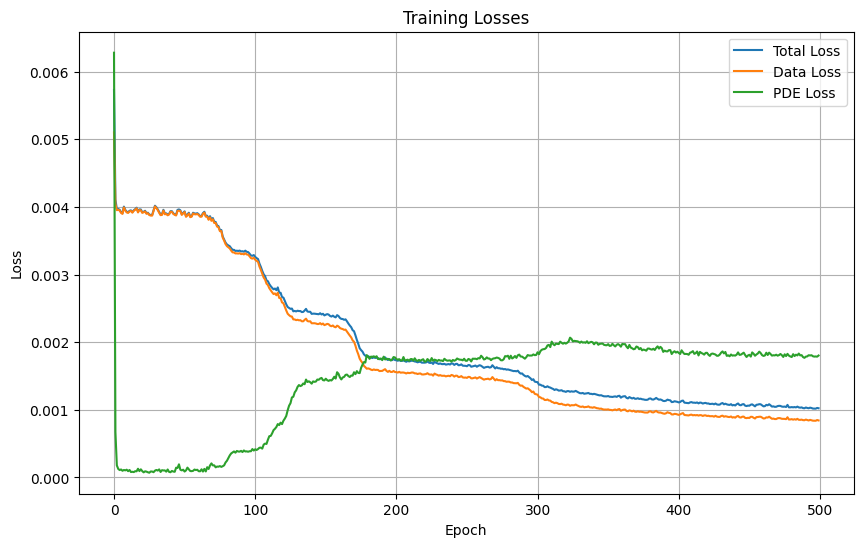

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Total Loss')
plt.plot(data_losses, label='Data Loss')
plt.plot(pde_losses, label='PDE Loss')
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
@torch.no_grad()
def evaluate(model, X, Y_true):
    model.eval()
    Y_pred = model(X)
    err = torch.sqrt(((Y_pred - Y_true)**2).mean()).item()
    return Y_pred.cpu().numpy(), err

Y_pred, rmse_val = evaluate(pinn, test_X, test_Y)

## Plot the predicted results

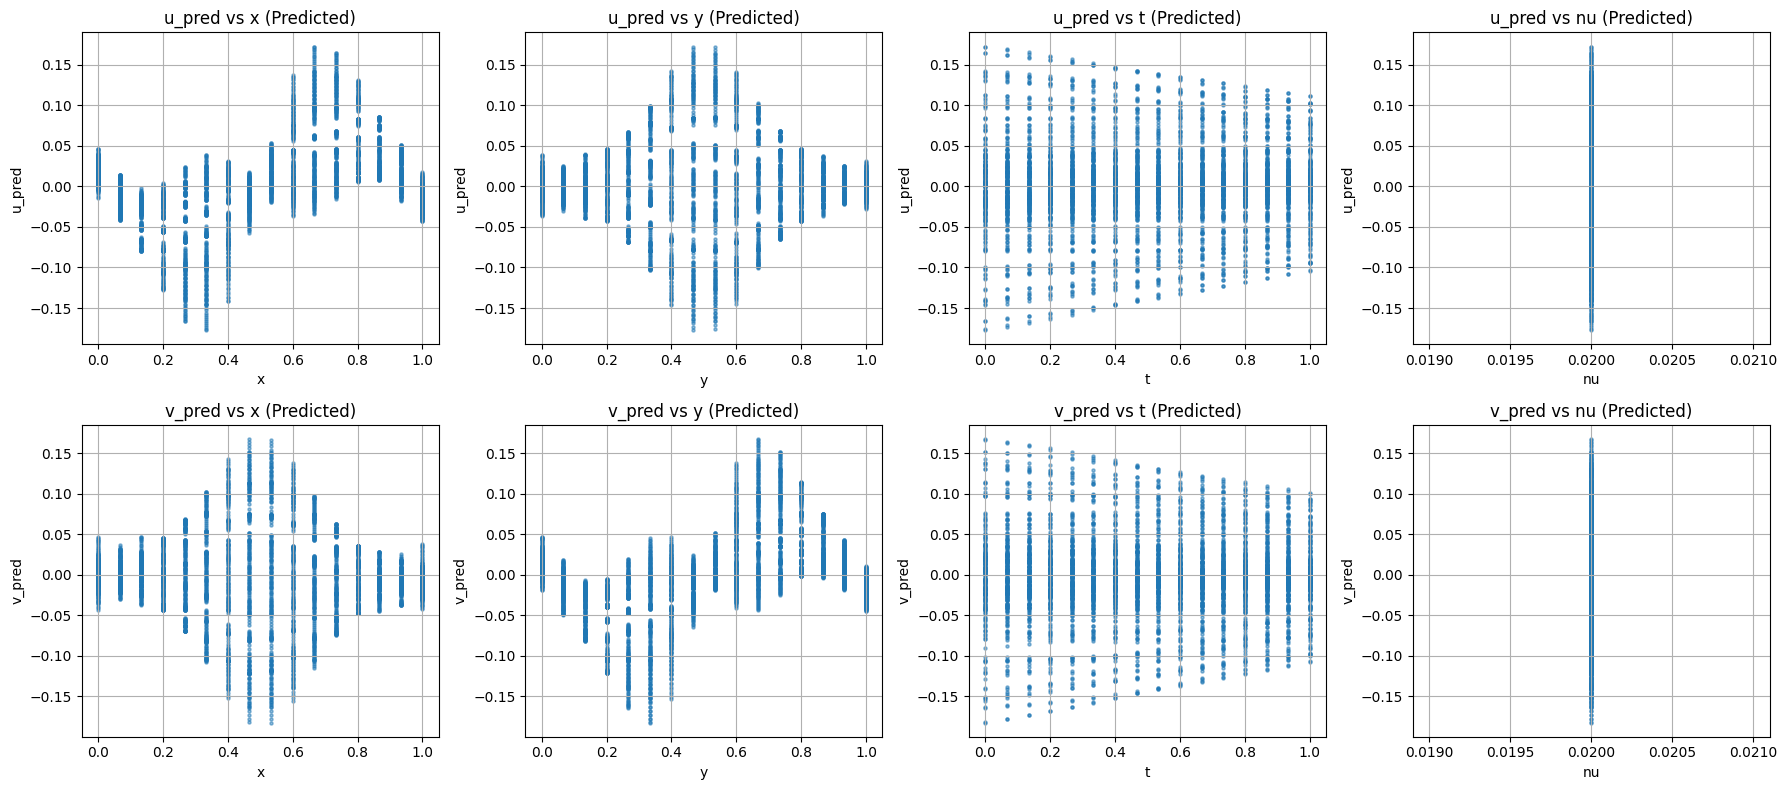

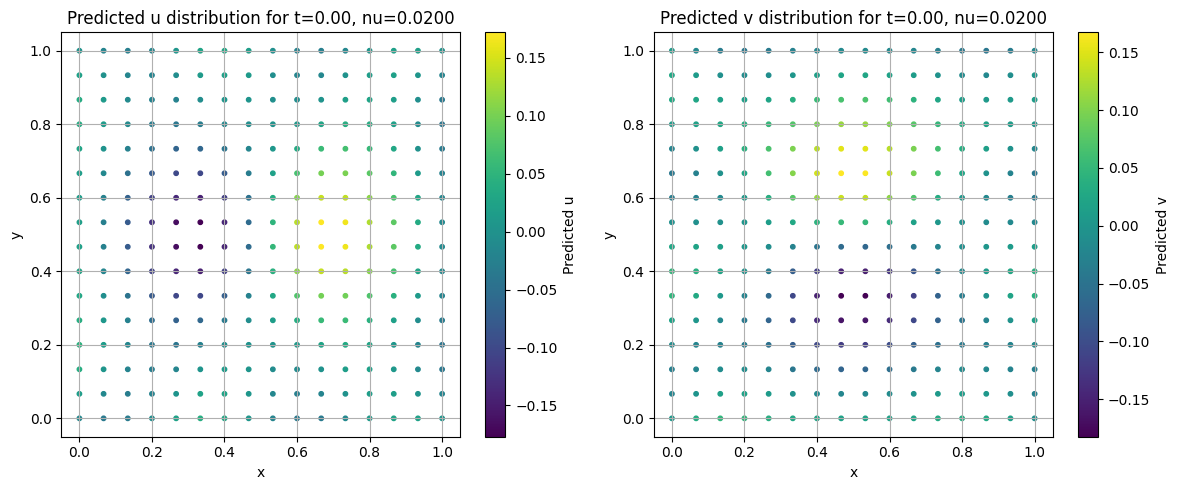

In [ ]:
# Convert tensors/numpy arrays to numpy for plotting (Y_pred is already numpy from evaluate function)
test_X_np = test_X.cpu().numpy()
Y_pred_np = Y_pred

# Plotting predicted u and v against each input feature of the test data

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
input_features = ['x', 'y', 't', 'nu']
output_features = ['u_pred', 'v_pred']

for i in range(4): # Loop over input features
    for j in range(2): # Loop over output features
        axes[j, i].scatter(test_X_np[:, i], Y_pred_np[:, j], s=5, alpha=0.5)
        axes[j, i].set_xlabel(input_features[i])
        axes[j, i].set_ylabel(f'{output_features[j]}')
        axes[j, i].set_title(f'{output_features[j]} vs {input_features[i]} (Predicted)')
        axes[j, i].grid(True)

plt.tight_layout()
plt.show()

# Example of a 2D slice plot for predicted values (e.g., u_pred vs x and y for fixed t and nu)
# This requires selecting a specific t and nu value from your test dataset.
# For simplicity, let's pick the first t and nu value in the test data

fixed_t_test = test_X_np[0, 2]
fixed_nu_test = test_X_np[0, 3]

# Filter test data for the chosen fixed values (with a small tolerance)
tolerance = 1e-5
mask_test = np.isclose(test_X_np[:, 2], fixed_t_test, atol=tolerance) & \
            np.isclose(test_X_np[:, 3], fixed_nu_test, atol=tolerance)

x_slice_test = test_X_np[mask_test, 0]
y_slice_test = test_X_np[mask_test, 1]
u_pred_slice = Y_pred_np[mask_test, 0]
v_pred_slice = Y_pred_np[mask_test, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_slice_test, y_slice_test, c=u_pred_slice, cmap='viridis', s=10)
plt.colorbar(label='Predicted u')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Predicted u distribution for t={fixed_t_test:.2f}, nu={fixed_nu_test:.4f}')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(x_slice_test, y_slice_test, c=v_pred_slice, cmap='viridis', s=10)
plt.colorbar(label='Predicted v')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Predicted v distribution for t={fixed_t_test:.2f}, nu={fixed_nu_test:.4f}')
plt.grid(True)

plt.tight_layout()
plt.show()